# Assignment 3 - Transfer Learning

### Name: Anirudh Swaminathan
### PID: A53316083
### Email ID: aswamina@eng.ucsd.edu

#### Notebook created by Anirudh Swaminathan from ECE department majoring in Intelligent Systems, Robotics and Control for the course ECE285 Machine Learning for Image Processing for Fall 2019

## Getting Started

In [52]:
# The below line does NOT work as the PDFs generated do not have the Images
# %matplotlib notebook
%matplotlib inline

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
# select the relevant device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Data Loader

#### Question 1

In [3]:
dataset_root_dir = '/datasets/ee285f-public/caltech_ucsd_birds/'

In [31]:
# Trying out getpass.getuser() and socket.gethostname()
import getpass
import socket

user = getpass.getuser()
hostname = socket.gethostname()
print(user)
print(hostname)

aswamina
aswamina-13662


We have created the $dataset\_root\_dir$ and made it point to the Bird dataset directory

#### Question 2

In [4]:
class BirdsDataset(td.Dataset):
    
    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        
        # data is a pandas DataFrame
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})".format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        # For the idxth entry, choose the value that is in the column file_path
        img_path = os.path.join(self.images_dir, self.data.iloc[idx]['file_path'])
        
        # the bounding box coordinates are at the x1, y1, x2, and y2 columns
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        
        # DEBUG
        # print(img_path)
        # print(bbox)
        
        # open the image
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
            # resize the image to image_size
            tv.transforms.Resize(self.image_size),
            
            # convert to torch tensor
            tv.transforms.ToTensor(),
            
            # Normalize each channel from [-1, 1]
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        # apply the transform on the image
        x = transform(img)
        
        # access the data from the panda DataFrame at the idxth row and the class column
        d = self.data.iloc[idx]['class']
        
        # DEBUG
        # print(d)
        return x, d
    
    def number_of_classes(self):
        return self.data['class'].max() + 1

Completed the torchvision transforms compose function. <br>
I resize the image using $tv.transforms.Resize()$ function. Then the image is converted to a torch tensor using the $tv.transforms.ToTensor()$ function. <br>
$$\textbf{NOTE:-} \text{The }tv.trasforms.ToTensor() \text{ converts the PIL image from range }(0, 255) \text{ to a tensor of range }(0, 1)$$
Finally, I normalize the image using the $tv.transforms.Normalize()$ function. <br>
This function takes means and standard deviations for each channel as the input. Since each channel has been transformed to $(0, 1)$ by the $tv.transforms.ToTensor()$ function, we have the mean for each channel is $0.5$ and the standard deviation is $0.5$. <br>
As given in the $PyTorch$ source code and documentation, the $tv.transforms.Normalize()$ function subtracts the mean for each channel from the image, and then divides by the standard deviation, so now the tensor in the range from $(0, 1)$ is converted to $\left( \frac{(0-0.5)}{0.5}, \frac{(1-0.5)}{0.5} \right)$, which is $(-1, 1)$.

#### Question 3

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image<0] = 0
    image[image>1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

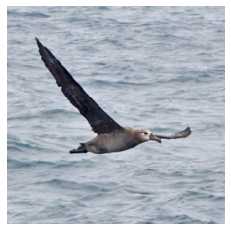

In [53]:
# train_set is an instance of BirdDataset
train_set = BirdsDataset(root_dir=dataset_root_dir)

# access the element at the 10th index
x, d_x = train_set.__getitem__(10)

# myimshow to display the obtained image
myimshow(x)

In [32]:
print(type(x), x.min(), x.max(), x.dtype)
print(x.shape)
print(d_x, type(d_x), d_x.dtype)

<class 'torch.Tensor'> tensor(-0.9843) tensor(0.9294) torch.float32
torch.Size([3, 224, 224])
0 <class 'numpy.int64'> int64


Created the object $train\_set$ as an instance of $BirdsDataset$. <br>
I sampled the element at index $10$ and stored it in the variable $x$. <br>
I finally used the $myimshow()$ function that was defined to display the image $x$.

#### Question 4

In [33]:
train_loader = td.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)

In [34]:
print(type(train_loader), len(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'> 47


$\text{I created } train\_loader \text{ that is defined to load the dataset. }$
$\text{The } train\_loader \text{ object acts on the } train\_set \text{.}$
$\text{I set the } batch\_size \text{ as } 16 \text{ to sample minibatches of size } 16 \text{.}$
$\text{I set shuffle = } True \text{ to have the data reshuffled at each epoch.}$
$\text{The } pin\_memory \text{ was also set to } True \text{ .}$
$\text{Setting } pin\_memory \text{ to } True \text{ enables fast data transfer to CUDA-enabled GPUs.}$
$\text{As given in the } PyTorch \text{ documentation, host to GPU copies are much faster when they originate from pinned (page-locked) memory.}$
$\text{CPU tensors and storages expose a } pin\_memory() \text{ method, that returns a copy of the object, with data put in a pinned region.}$
$\text{Since we have set the } drop\_last \text{ argument as } False \text{ by default, the last minibatch is allowed to be of lower size than } 16 \text{.}$
$$\textbf{Number of minibatches:- }$$
$$\text{Number of training minibatches per epoch } = \frac{\text{Total number of training images}}{\text{Batch size}}$$
$$\text{Number of training minibatches per epoch } = \frac{743}{16}$$
$$\text{Number of training minibatches per epoch } = 46 + 1 = 47$$
$\text{In one training epoch, we have } 46 \text{ minibatches each of size } 16 \text{ and the } 47^{th} \text{ minibatch is of size } 7.$

#### Question 5

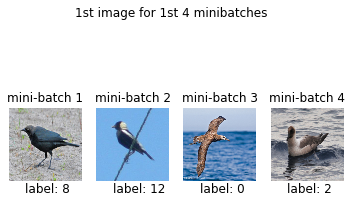

In [55]:
# Display 1st image and label pair for the 1st 4 minibatches
fig, axes = plt.subplots(ncols=4)
fig.suptitle("1st image for 1st 4 minibatches")

for bind, mbat in enumerate(train_loader):
    # print(len(mbat))
    # print(type(mbat[0]), type(mbat[1]))
    # print(mbat[0].size(), mbat[1].size())
    
    # The dataloader returns both the image and the label
    # image is in the 0th index, label is 1st index
    img = mbat[0][0, :, :, :]
    lab = mbat[1][0]
    # print(lab.item())
    myimshow(img, ax=axes[bind])
    axes[bind].text(50, 250, "label: {}".format(lab.item()), size=12, verticalalignment='center')
    # axes[bind].set_ylabel("label: {}".format(lab.item()))
    axes[bind].set_title("mini-batch {}".format(bind+1))
    if bind == 3:
        break

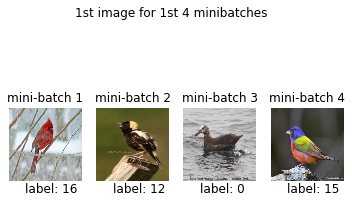

In [56]:
# Display 1st image and label pair for the 1st 4 minibatches
fig, axes = plt.subplots(ncols=4)
fig.suptitle("1st image for 1st 4 minibatches")

for bind, mbat in enumerate(train_loader):
    # print(len(mbat))
    # print(type(mbat[0]), type(mbat[1]))
    # print(mbat[0].size(), mbat[1].size())
    
    # The dataloader returns both the image and the label
    # image is in the 0th index, label is 1st index
    img = mbat[0][0, :, :, :]
    lab = mbat[1][0]
    # print(lab.item())
    myimshow(img, ax=axes[bind])
    axes[bind].text(50, 250, "label: {}".format(lab.item()), size=12, verticalalignment='center')
    # axes[bind].set_ylabel("label: {}".format(lab.item()))
    axes[bind].set_title("mini-batch {}".format(bind+1))
    if bind == 3:
        break

I have displayed the $1^{st}$ image and label pair for the $1^{st}$ $4$ mini-batches. <br>
I re-evaluated my cell, i.e., displayed the same information again in another cell. <br>
I obtained different results compared to running it for the $1^{st}$ time. <br>
This is because the $train\_loader$ creates a random minibatch shuffle every epoch.

#### Question 6

In [7]:
val_set = BirdsDataset(root_dir=dataset_root_dir, mode="val")

In [8]:
val_loader = td.DataLoader(val_set, batch_size=16, pin_memory=True)

I have created $val\_set$ as an instance of BirdsDataset using $mode="val"$. <br>
I then created $val\_loader$ to load the $val\_set$. <br>
Shuffle is not required for the validation dataset as the parameters of the network are not affected by the validation set. <br>
Since the trained weights are just going to forward propagate the validation set images through the network just once to produce the outputs, we do not need to shuffle it. <br>
On the other hand, shuffling the data is required for the training set of images. This is because the network has to backpropogate the errors and learn the optimal network parameters using SGD. <br>
When using SGD, it is best to randomly shuffle the data to avoid local optima and to avoid training the network to recognize a particular sequence of inputs.

## Abstract Neural Network Model

In [9]:
import nntools as nt

In [37]:
help(nt.NeuralNetwork)

Help on class NeuralNetwork in module nntools:

class NeuralNetwork(torch.nn.modules.module.Module, abc.ABC)
 |  An abstract class representing a neural network.
 |  
 |  All other neural network should subclass it. All subclasses should override
 |  ``forward``, that makes a prediction for its input argument, and
 |  ``criterion``, that evaluates the fit between a prediction and a desired
 |  output. This class inherits from ``nn.Module`` and overloads the method
 |  ``named_parameters`` such that only parameters that require gradient
 |  computation are returned. Unlike ``nn.Module``, it also provides a property
 |  ``device`` that returns the current device in which the network is stored
 |  (assuming all network parameters are stored on the same device).
 |  
 |  Method resolution order:
 |      NeuralNetwork
 |      torch.nn.modules.module.Module
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initializes internal Module state

#### Question 7

In [38]:
net = nt.NeuralNetwork()

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

I observe that on running the above line of code, I am getting a $TypeError$. <br>
The exact error message is that I can't instantiate abstract class NeuralNetwork with abstract methods criterion and forward. <br>
As given in the question, an abstract class does not implement all of its methods and cannot be instantiated.

In [10]:
class NNClassifier(nt.NeuralNetwork):
    
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

We have also defined the $NNClassifier$ that inherits from $NeuralNetwork$, and defines only the $criterion$. <br>
Here, the $criterion$ method is implemented to be the cross-entropy loss. But this class is still abstract as it does not implement the $forward$ method.

## VGG-16 Transfer Learning

#### Question 8

In [39]:
vgg = tv.models.vgg16_bn(pretrained=True)

In [40]:
# print the network
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

I have thus printed the network architecture using the $print(vgg)$ function.

In [41]:
# print the named parameters of the network
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

I inspected all the named parameters of the network, and I find that all of the parameters are learnable parameters, as the $requires\_grad$ attribute is set to $True$ for all of them.

#### Question 9

In [11]:
class VGG16Transfer(NNClassifier):
    
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            # if we do not want to fine tune the network, then fine_tuning=False
            # this means that we need to freeze these VGG16 pretrained layers 
            # and NOT train them when not fine-tuning
            param.requires_grad = fine_tuning
        self.features = vgg.features
        
        # COMPLETE
        # the average pooling is the same
        self.avgpool = vgg.avgpool
        # the classifier is also the same
        self.classifier = vgg.classifier
        
        # CODE to change the final classifier layer
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        # COMPLETE the forward prop
        f = self.features(x)
        f = self.avgpool(f)
        f = torch.flatten(f, 1)
        y = self.classifier(f)
        return y

I have created the subclass $VGG16Transfer$ that inherits from $NNClassifier$. <br>
I copied the layers of the $VGG16$ pretrained network to my classifier. This included the Sequential features, the average pooling layer, and the Sequential classifier. I modified the final layer of my classifier to be trained specific to my task. <br>
I finally implemented the $forward()$ method of my network and thus, this class is no longer an abstract class.

#### Question 10

In [12]:
num_classes = train_set.number_of_classes()
print(num_classes)

20


In [13]:
net = VGG16Transfer(num_classes)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:12<00:00, 43.5MB/s] 


In [42]:
# print the network
print(net)

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

I have thus printed the network architecture using the $print(net)$ function. <br>
The difference between this network and the $VGG$ pretrained net is that there is a $cross\_entropy$ criterion for the loss. <br>
Also, the final layer in the classifier is defined to be connecting $4096$ to $20$, which is the number of classes instead of $1000$ as defined in the original VGG network. 

In [43]:
# print the named parameters of the network
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

classifier.6.weight torch.Size([20, 4096]) True
classifier.6.bias torch.Size([20]) True


I inspected all the named parameters of the network. <br>
The only learnable parameters are for the final Fully Connected (FC) layer of the classifier, which is specific to our given task, and is different from the pre-trained $VGG$ network. <br>
This is because we had explicitly set the $requires\_grad$ attribute of all the other parameters of the network to $False$ to avoid training the entire network and to leverage the pre-trained weights for these layers. <br>
Since we modified the final Fully Connected Layer of the classifier, we created a new $nn.Linear$ layer, whose $requires\_grad$ is by default set to $True$, and thus only that layer is learnable for our network.

## Training experiment and checkpoints

#### Question 11

In [14]:
class ClassificationStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        
        # Gets the indices of the maximum activation of softmax for each sample
        _, l = torch.max(y, 1)
        
        # count the running average fraction of correctly classified samples
        self.running_accuracy += torch.mean((l == d).float())
        
    def summarize(self):
        # this is the average loss when called
        loss = super(ClassificationStatsManager, self).summarize()
        
        # this is the average accuracy percentage when called
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss' : loss, 'accuracy' : accuracy}

Created a subclass $ClassificationStatsManager$ that inherits from $StatsManager$ and overloads each method. <br>
The additional information apart from the running loss is the running accuracy that is also being tracked here. <br>
In $init()$, the running accuracy is set to $0$. The $accumulate()$ method adds the mean accuracy for each minibatch to the running accuracy. <br>
Finally, the $summarize()$ method is overloaded to set the accuracy to the average over all the epochs/updates. <br>

#### Question 12

I read the documentation for the $evaluate()$ method. $self.net$ is set to $eval$ mode by the $eval()$ function. <br>
This ensures that the model is in evaluation mode while testing. This is to ensure that only those modules like Dropout, Batchnorm, etc. that behave differently during training and testing behave correctly. <br>
For example, Dropout, as given in the documentation, during training, randomly zeroes some of the elements of the input tensor with probability $p$ using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call. <br>
This means that during evaluation the module simply computes an identity function. <br>
Hence, to ensure that this behaviour is followed, we call the $eval()$ function on the module first. <br>
Once the $evaluate()$ function is computed, we again set the network to the train mode using the $train()$ method so that it can continue with the training.

#### Question 13

In [15]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam,
                     stats_manager, output_dir="birdclass1",
                     perform_validation_during_training=True)

I have checked that the directory $birdclass1$ has been created. <br>
Inspecting its contents, I find that it contains $2$ files, namely $checkpoint.pth.tar$ and $config.txt$. <br>
Visualizing the $config.txt$ file, and also from the code in the $nntools.py$ class,  I find that it corresponds to the settings of the experiment. <br>
So, $config.txt$ contains the network parameters, the training set, the validation set, the optimizer, the stats manager I am using, the batch size, and the boolean value for $perform\_validation\_during\_training$. <br>
The file $checkpoint.pth.tar$ corresponds to saving the $state\_dict()$ of the model. It consists of the dictionary of key-value pairs. <br>
The 'Net' attribute corresponds to the networks $state\_dict()$, the 'Optimizer' corresponds to the optimizers $state\_dict()$ and 'History' corresponds to the history of the training of the network. <br>
The $checkpoint.pth.tar$ file was saved using the $torch.save()$ function that saves the models $save\_dict()$ to the file with the name contained in the variable $checkpoint\_path$.

#### Question 14

In [44]:
lr = 1e-4
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam,
                     stats_manager, output_dir="birdclass1",
                     perform_validation_during_training=True)

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.

On running the same code with just a different learning rate (LR), we have accessed the same folder and the same checkpoint file. <br>
Since the settings here are different, this means that we are supposed to create a separate folder for the same, as it is a different experiment. <br>
Hence, a $ValueError$ is raised, with the error message $\textbf{"Cannot create this experiment: I found a checkpoint conflicting with the current setting."}$. <br>

In [45]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam,
                     stats_manager, output_dir="birdclass1",
                     perform_validation_during_training=True)

On changing the learning rate(LR) back to $1^{-3}$, we can access the same checkpoint folder and file, as all the network settings are the same, including the learning rate. <br>
This means that the checkpoint is now just loaded onto the program, as there is no conflict with the settings of the network.

#### Question 15

In [16]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    
    # Plot the training loss over the epochs
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                label="training loss")
    
    # Plot the evaluation loss over the epochs
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                color='orange', label="evaluation loss")
    
    # legend for the plot
    axes[0].legend()
    
    # xlabel and ylabel
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    
    # Plot the training accuracy over the epochs
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                label="training accuracy")
    
    # Plot the evaluation accuracy over the epochs
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                color='orange', label="evaluation accuracy")
    
    # legend for the plot
    axes[1].legend()
    
    # xlabel and ylabel
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    
    plt.tight_layout()
    
    # set the title for the figure
    # fig.suptitle("Loss and Accuracy metrics")
    fig.canvas.draw()

I have completed the $plot()$ function to plot the different metrics for $20$ epochs. <br>
I access the $k^{th}$ epoch using the $history[k]$ index. <br>
I then access the metrics evaluated on the training set using the $0^{th}$ index. I access the metrics evaluated on the validation set using the $1^{st}$ index. <br>
To access the loss, we use the loss as key value for the dictionary. To access the accuracy, we use accuracy as the key value for the dictionary. <br>
To get the orange colour for the plot, we use the $color="orange"$ as another parameter in the $plot()$ function in the axes. <br>
To set the X Label and Y Label for each subplot, we use the $set\_xlabel()$ and the $set\_ylabel()$ methods respectively. <br>
To set the legend for the subplots, since we have already specified the $label$ for each subplot, we just need to call the $legend()$ function for each subplot. <br>

Start/Continue training from epoch 20
Finish training for 20 epochs


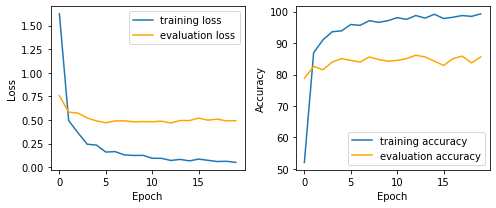

In [57]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

I have run the $1^{st}$ experiment using $VGG16$ for Transfer Learning on the GPU, with Adam Optimizer and with learning rate = $1^{-3}$. <br>
The training has been completed for $20$ epochs, and we have got $2$ plots, one each for loss and accuracy for the training and the validation set with the number of epochs. <br>
For each epoch, it takes about $25$ seconds to run on the GPU. <br>
The loss evolutions as well as the accuracy evolutions are found to be consistent with the ones given to us.

## ResNet18 Transfer Learning

In [46]:
resnet = tv.models.resnet18(pretrained=True)

In [47]:
# print the network
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

I have thus printed the network architecture using the $print(resnet)$ function.

In [48]:
# print the named parameters of the network
for name, param in resnet.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) True
bn1.weight torch.Size([64]) True
bn1.bias torch.Size([64]) True
layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) True
layer1.0.bn1.weight torch.Size([64]) True
layer1.0.bn1.bias torch.Size([64]) True
layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) True
layer1.0.bn2.weight torch.Size([64]) True
layer1.0.bn2.bias torch.Size([64]) True
layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) True
layer1.1.bn1.weight torch.Size([64]) True
layer1.1.bn1.bias torch.Size([64]) True
layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) True
layer1.1.bn2.weight torch.Size([64]) True
layer1.1.bn2.bias torch.Size([64]) True
layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) True
layer2.0.bn1.weight torch.Size([128]) True
layer2.0.bn1.bias torch.Size([128]) True
layer2.0.conv2.weight torch.Size([128, 128, 3, 3]) True
layer2.0.bn2.weight torch.Size([128]) True
layer2.0.bn2.bias torch.Size([128]) True
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1]) True
layer2.

#### Question 16

In [18]:
class Resnet18Transfer(NNClassifier):
    
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            # if we do not want to fine tune the network, then fine_tuning=False
            # this means that we need to freeze these VGG16 pretrained layers 
            # and NOT train them when not fine-tuning
            param.requires_grad = fine_tuning
        
        # network definition
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        # the "layers" now
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # the average pooling is the same
        self.avgpool = resnet.avgpool
        
        # the classifier is also the same
        self.fc = resnet.fc
        
        # CODE to change the FC layer
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        # forward prop through the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        f = self.layer1(x)
        f = self.layer2(f)
        f = self.layer3(f)
        f = self.layer4(f)
        
        a = self.avgpool(f)
        a = torch.flatten(a, 1)
        y = self.fc(a)
        return y

I created the $Resnet18Transfer$ class that inherits from $NNClassifier$. <br>
I copied the layers of the $Resnet18$ pretrained network to my classifier. I modified the final fully connected (FC) layer of my classifier to be trained specific to my task. <br>
I finally implemented the $forward()$ method of my network and thus, this class is no longer an abstract class.

#### Question 17

In [49]:
re_net = Resnet18Transfer(num_classes)

In [50]:
print(re_net)

Resnet18Transfer(
  (cross_entropy): CrossEntropyLoss()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

I have thus printed the network architecture using the $print(re\_net)$ function. <br>
The difference between this network and the $Resnet18$ pretrained net is that there is a $cross\_entropy$ criterion for the loss. <br>
Also, the final layer in the classifier is defined to be connecting $512$ to $20$, which is the number of classes instead of $1000$ as defined in the original Resnet18 network. 

In [51]:
# print the named parameters of the network
for name, param in re_net.named_parameters():
    print(name, param.size(), param.requires_grad)

fc.weight torch.Size([20, 512]) True
fc.bias torch.Size([20]) True


I inspected all the named parameters of the network. <br>
The only learnable parameters are for the final Fully Connected (FC) layer of the classifier, which is specific to our given task, and is different from the pre-trained $Resnet18$ network. <br>
This is because we had explicitly set the $requires\_grad$ attribute of all the other parameters of the network to $False$ to avoid training the entire network and to leverage the pre-trained weights for these layers. <br>
Since we modified the final Fully Connected Layer of the classifier, we created a new $nn.Linear$ layer, whose $requires\_grad$ is by default set to $True$, and thus only that layer is learnable for our network.

In [19]:
lr = 1e-3
re_net = Resnet18Transfer(num_classes)
re_net = re_net.to(device)
adam = torch.optim.Adam(re_net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(re_net, train_set, val_set, adam,
                     stats_manager, output_dir="birdclass2",
                     perform_validation_during_training=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg-cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 30.4MB/s]


I have checked that the directory $birdclass2$ has been created. <br>
Inspecting its contents, I find that it contains $2$ files, namely $checkpoint.pth.tar$ and $config.txt$. <br>
Visualizing the $config.txt$ file, and also from the code in the $nntools.py$ class,  I find that it corresponds to the settings of the experiment. <br>
So, $config.txt$ contains the network parameters, the training set, the validation set, the optimizer, the stats manager I am using, the batch size, and the boolean value for $perform\_validation\_during\_training$. <br>
The file $checkpoint.pth.tar$ corresponds to saving the $state\_dict()$ of the model. It consists of the dictionary of key-value pairs. <br>
The 'Net' attribute corresponds to the networks $state\_dict()$, the 'Optimizer' corresponds to the optimizers $state\_dict()$ and 'History' corresponds to the history of the training of the network. <br>
The $checkpoint.pth.tar$ file was saved using the $torch.save()$ function that saves the models $save\_dict()$ to the file with the name contained in the variable $checkpoint\_path$.

<IPython.core.display.Javascript object>


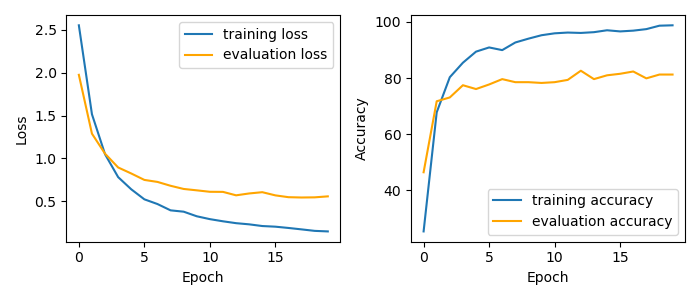

Start/Continue training from epoch 0
Epoch 1 (Time: 26.46s)
Epoch 2 (Time: 25.85s)
Epoch 3 (Time: 26.23s)
Epoch 4 (Time: 26.25s)
Epoch 5 (Time: 25.78s)
Epoch 6 (Time: 25.83s)
Epoch 7 (Time: 25.86s)
Epoch 8 (Time: 25.78s)
Epoch 9 (Time: 26.17s)
Epoch 10 (Time: 25.87s)
Epoch 11 (Time: 26.13s)
Epoch 12 (Time: 26.42s)
Epoch 13 (Time: 26.36s)
Epoch 14 (Time: 26.34s)
Epoch 15 (Time: 25.88s)
Epoch 16 (Time: 26.11s)
Epoch 17 (Time: 26.39s)
Epoch 18 (Time: 26.16s)
Epoch 19 (Time: 26.34s)
Epoch 20 (Time: 25.99s)
Finish training for 20 epochs


In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

Start/Continue training from epoch 20
Finish training for 20 epochs


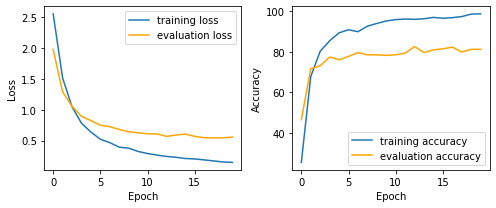

In [58]:
# I'm running this cell again because matplotlib inline does not work!
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

I have run the $2^{nd}$ experiment using $ResNet18$ for Transfer Learning on the GPU, with Adam Optimizer and with learning rate = $1^{-3}$. <br>
The training has been completed for $20$ epochs, and we have got $2$ plots, one each for loss and accuracy for the training and the validation set with the number of epochs. <br>
For each epoch, it takes about $26$ seconds to run on the GPU. <br>
The loss evolutions as well as the accuracy evolutions are found to be consistent with the ones given to us.

#### Question 18

In [21]:
# Compute the validation performance obtained by exp1
vgg_val = exp1.evaluate()
print(vgg_val)

{'loss': 0.4929845600753375, 'accuracy': tensor(85.5978, device='cuda:0')}


In [29]:
print("Loss of network on validation set using VGG16 as the frozen model after 20 epochs is %.3f" % vgg_val['loss'])
print("Accuracy of the network on validation set using VGG16 as the frozen model after 20 epochs is %.3f" % vgg_val['accuracy'].item(), "%")

Loss of network on validation set using VGG16 as the frozen model after 20 epochs is 0.493
Accuracy of the network on validation set using VGG16 as the frozen model after 20 epochs is 85.598 %


In [22]:
# Compute the validation performance  obtained by exp2
resnet_val = exp2.evaluate()
print(resnet_val)

{'loss': 0.5576237161522326, 'accuracy': tensor(81.2500, device='cuda:0')}


In [30]:
print("Loss of network on validation set using Resnet18 as the frozen model after 20 epochs is %.3f" % resnet_val['loss'])
print("Accuracy of the network on validation set using Resnet18 as the frozen model after 20 epochs is %.3f" % resnet_val['accuracy'].item(), "%")

Loss of network on validation set using Resnet18 as the frozen model after 20 epochs is 0.558
Accuracy of the network on validation set using Resnet18 as the frozen model after 20 epochs is 81.250 %


We used the $evaluate()$ method of $Experiment$ to compare the validation performance obtained by $exp1$ and $exp2$ using $VGG16Transfer$ and $Resnet18Transfer$ respectively. <br>

### Observations
$$\textbf{Loss for the trained networks on the validation set}$$
The loss for $VGG16$ pre-trained network on the validation set after $20$ epochs is $0.493$. <br>
The loss for $Resnet18$ pre-trained network on the validation set after $20$ epochs is $0.558$. <br>
$$\textbf{Accuracy for the trained networks on the validation set}$$
The accuracy for $VGG16$ pre-trained network on the validation set after $20$ epochs is $85.598\%$. <br>
The accuracy for $Resnet18$ pre-trained network on the validation set after $20$ epochs is $81.250\%$.

### Inferences
We infer that the $VGG16$ pre-trained network performs better for the same Learning rate and Adam optimization for our particular task of classifying birds. <br>
The $Resnet18$ pre-trained network on the other hand has worse loss on the validation set, i.e., its validation loss is higher compared to the validation loss of $VGG16$ pre-trained network on the same dataset. <br>
Likewise, it has worse classification accuracy on the validation set, i.e., its validation accuracy is lower compared to the validation accuracy of $VGG16$ pre-trained network on the same dataset.

### Conclusion
Thus, we have explored a new dataset this homework, which is the Caltech-UCSD Birds Dataset. <br>
We have explored $PyTorch$ $Dataset$ class, $DataLoader$, and how to define and use abstract neural network module classes, and then implement a specific network for our own purposes. <br>
We then learnt how to load pre-trained models such as $VGG16$ and $Resnet18$ using $PyTorch$. <br>
We then used these models in transfer learning to specifically work for our limited dataset by freezing all the layers except the final one. <br>
Finally, we learnt how to create checkpoints to stop and resume model training.

$$\textbf{Assignment completed by:-} \\
    \text{Name: Anirudh Swaminathan } \\
    \text{PID: A53316083 } \\
    \text{Email ID: aswamina@eng.ucsd.edu}$$